# [Section2 Sprint3] wrap-up

* 아래 내용은, 제가 현재 조금씩 집필하고 있는 책의 내용 일부입니다.
* 여러분을 위해서 어제밤 늦게까지 편집하며 준비했답니다...^^;;;
* 조금 유치하더라도, 열심히 들어주세요~~~~

--------

# 신용대출 심사

* 고객사는 ## 은행입니다. 신용평가 업무를 인공지능으로 전환하고자 **코드스테이츠 부트캠프 여러분**에게 모델링을 의뢰하였습니다.  
~(아니, 우리에게 왜???)~
* 대출업무는
    * 은행 창구에서 신청을 받고
    * 본사의 심사부서에서는 신용평가를 통해 대출 신청에 대한 승인 여부를 결정해 왔습니다.

* 현장의 요구
    * 경쟁사의 공격적인 대출상품 판매로, 본사에서는 자사 은행의 대출 실적이 줄어들고 있어 **수익 하락**으로 인한 부담을 느끼고 있습니다.
    * 그런데, 자사 은행에서는 신용평가 결과의 정확성에 의문을 품고 있으며, 신용평가 기준을 완화하여 가급적 대출승인 범위를 더 확대해 주기를 요구합니다. 

* 신용평가 업무를 인공지능으로 전환
    * 현장의 요구를 감안하여, 과거 사람이 하던 평가방식을 개선하고자 인공지능에 의한 예측 모델을 만들고, 정확도를 높이고자 합니다.
    * 그래서 결국 해결하고자 하는 것는 **수익 문제** 입니다.
-----------------


![](https://www04.wellsfargomedia.com/assets/video/home-lending-shared/the-role-of-your-credit-history/the-role-of-your-credit-history_720x404.jpg)

![](https://github.com/DA4BAM/image/blob/main/CRISP-DM.png?raw=true)

## 0.준비작업

### (1) 라이브러리 설치

In [3]:
!pip install shap
!pip install category_encoders
!pip install pdpbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 KB 2.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached PDPbox-0.2.1.tar.gz (34.0 MB)
  Preparing metadata (setup.py) ... done
  Using cached matplotlib-3.1.1.tar.gz (37.8 MB)
  Preparing metadata (setup.py) ... done
  Using cached sklearn-0.0.post1.tar.gz (3.6 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for pdpbox: filename=PDPbox-0.2.1-py3-none-any.whl size=35758224 sha256=cd9bd87bd2b5132275e70d0a6b40e5ded386483c5be6a15965ef49301ac90158
  Stored in directory: /root/.cache/pip/wheels/f2/5e/63/62e00a642415e064a55f53b5095ceb1420d24685125420d3ac
  Created wheel for matplotlib: filename=matplotlib-3.1.1-cp39-cp39-linux_x86_64.whl size=1206024

* 런타임 다시 시작~!

### (2) 라이브러리, 데이터 로딩

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import *

import shap
from pdpbox.pdp import pdp_isolate, pdp_plot

* 변수 중요도 그래프 함수 만들기

In [2]:
# 변수 중요도 plot
def plot_feature_importance(importance, names, topn = 'all'):

    # 변수 중요도와 변수 이름을 정렬해서 df로 저장
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    # 변수가 너무 많으면 보기 어려우니, top N 지정
    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    # 그래프 그리기
    plt.figure(figsize=(10,8))
    sns.barplot(x='feature_importance', y='feature_names', data = fi_df)
    plt.xlabel('importance')
    plt.ylabel('feature names')
    plt.grid()

    # 저장한 변수 중요도 df 반환
    return fi_df

* 데이터 로딩

In [3]:
path = 'https://raw.githubusercontent.com/DA4BAM/dataset/master/credit_all.csv'
data = pd.read_csv(path)
data.drop(['Telephone','ForeignWorker'], axis = 1, inplace = True)
data.loc[data['Payment'] == 4, 'Payment'] = 3
data.head()

,Creditability,AccountBalance,Duration,Payment,Purpose,CreditAmount,Employment,SexMarital,CurrentAddress,MostValuableAsset,Age,Apartment,CreditCount,Occupation,Dependents
0,1,3,24,2,0,1249,2,4,2,1,28,2,1,3,1
1,1,2,9,2,0,276,3,4,4,1,22,1,1,2,1
2,1,1,18,3,2,1049,2,2,4,2,21,1,1,3,1
3,1,1,24,3,1,6419,5,2,4,4,44,3,2,4,2
4,1,3,12,2,2,1424,5,2,4,1,55,2,1,4,1


|	칼럼명	|	설명	|	 	|	값 의미	|
|	-----	|	-----	|	-----	|	-----	|
|	Creditability	|	Creditability(Target)	|	향후 신용도	|	0 : Bad, 1 : Good	|
|	AccountBalance	|	Account Balance	|	은행잔고	|	1: No account, 2 : None (No balance), 3 : Some Balance	|
|	CreditDuration	|	Duration of Credit (month)	|	신청한 대출기간(월)	|	숫자	|
|	Payment	|	Payment Status of Previous Credit	|	과거 대출 납입 상태	|	0 : 연체, 1 : 기타신용, 2 : 완납, 3 : 정상 대출상환 중 |
|	Purpose	|	Purpose	|	신청한 대출목적	|	1 : New Car , 2 : Used Car , 3 : Furniture , 4 : TV , 5 : Appliances , 6 : Repair , 8 : Vacation , 9 :Retraining , 10 : Business , 0 : Other	|
|	CreditAmount	|	Credit Amount($)	|	신청한 대출금액	|		|
|	Employment	|	Length of current employment(Month)	|	현 직업 근무 기간	|	1: Unemployed,  2: <1 Year,  3: [1, 4),  4: [4, 7),  5: Above 7	|
|	SexMarital	|	Sex & Marital Status	|	성별 & 결혼상태	|	1: Male, Divorced, 2: Male, Single , 3: Male, Married/Widowed , 4: Female	|
|	CurrentAddress	|	Duration in Current address	|	현 거주지 거주기간	|	1: <1 Year , 2: [1, 4) , 3: [4, 7) , 4: Above 7	|
|	MostValuable	|	Most valuable available asset	|	가장 가치있는 자산	|	1: Real Estate , 2: Car , 3: Life Insurance , 4: None	|
|	Age	|	Age (years)	|	나이	|		|
|	AppartmentType	|	Type of apartment	|	주거환경	|	1: free apartment, 2: Rented, 3: Owned	|
|	NoCredits	|	No of Credits at this Bank	|	현재 총 대출 건수	|	1 : one, 2 : 2 ~ 3, 3 : 4 ~ 5, 4 : 6 ~	|
|	Occupation	|	Occupation	|	직업	|	1: Unemployed, unskilled, 2: Unskilled Permanent Resident, 3: Skilled, 4: Executive	|



* 데이터의 크기를 살펴봅시다.

In [4]:
data.shape

(1000, 15)

* Target 변수 조회

1    700
0    300
Name: Creditability, dtype: int64
1    0.7
0    0.3
Name: Creditability, dtype: float64


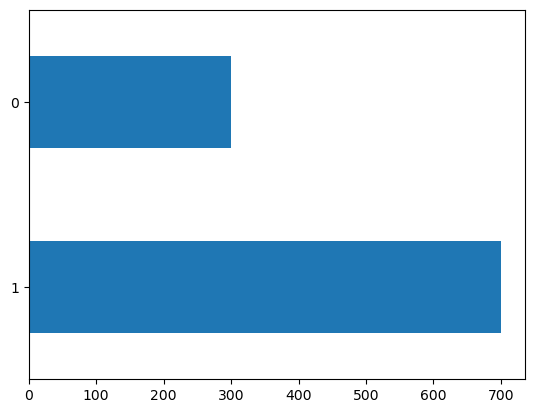

In [ ]:
print(data['Creditability'].value_counts())
print(data['Creditability'].value_counts(normalize = True))

data['Creditability'].value_counts().plot(kind = 'barh')
plt.show()

### (3) 데이터 준비


* x, y로 나누기 

In [6]:
target = 'Creditability'
x = data.drop(target, axis = 1)
y = data.loc[:,target]

* 가변수화

In [7]:
# 변수 중 순서형 범주들이 꽤 있어서 그넘들은 제외하고
# 순서가 없는 범주들(명목형 범주)만 가변수화를 수행합니다.

dummy_vars = [ 'Payment', 'Purpose', 'SexMarital', 'MostValuableAsset']
x = pd.get_dummies(x, columns = dummy_vars)
x.head()

,AccountBalance,Duration,CreditAmount,Employment,CurrentAddress,Age,Apartment,CreditCount,Occupation,Dependents,...,Purpose_9,Purpose_10,SexMarital_1,SexMarital_2,SexMarital_3,SexMarital_4,MostValuableAsset_1,MostValuableAsset_2,MostValuableAsset_3,MostValuableAsset_4
0,3,24,1249,2,2,28,2,1,3,1,...,0,0,0,0,0,1,1,0,0,0
1,2,9,276,3,4,22,1,1,2,1,...,0,0,0,0,0,1,1,0,0,0
2,1,18,1049,2,4,21,1,1,3,1,...,0,0,0,1,0,0,0,1,0,0
3,1,24,6419,5,4,44,3,2,4,2,...,0,0,0,1,0,0,0,0,0,1
4,3,12,1424,5,4,55,2,1,4,1,...,0,0,0,1,0,0,1,0,0,0


* train : validation 분할

In [8]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = .3, random_state = 20)

* 스케일링

In [9]:
scaler = MinMaxScaler()
x_train_s = scaler.fit_transform(x_train)
x_val_s = scaler.transform(x_val)

----

# 과제1. 모델이 신용도를 예측하는데 중요한 요인은?

* 고객에게 제공한 예측 모델
    * 여러분은 다양한 알고리즘과 튜닝을 통해 모델을 생성하였습니다.
    * 모델의 정확도가 상당히 높다고 평가 되었습니다.
    * 고객은 여러분의 결과물에 대해 기뻐하고 있습니다. 그리고 한가지 질문을 해 왔습니다.

![](https://github.com/DA4BAM/image/blob/main/%EB%AA%A8%EB%8D%B8%ED%95%B4%EC%84%9D1.png?raw=true)

-----

![](https://github.com/DA4BAM/image/blob/main/%EB%AA%A8%EB%8D%B8%ED%95%B4%EC%84%9D.png?raw=true)

## 1.다양한 모델 생성
* rf, knn, logistic regression 모델 성능 비고

### (1) RF

In [96]:
model1 = RandomForestClassifier()
model1.fit(x_train, y_train)

RandomForestClassifier()

In [97]:
pred1 = model1.predict(x_val)
print(confusion_matrix(y_val, pred1))
print(classification_report(y_val, pred1))

[[ 32  53]
 [ 18 197]]
              precision    recall  f1-score   support

           0       0.64      0.38      0.47        85
           1       0.79      0.92      0.85       215

    accuracy                           0.76       300
   macro avg       0.71      0.65      0.66       300
weighted avg       0.75      0.76      0.74       300



### (2) KNN

In [98]:
params = {'n_neighbors':range(1, 50), 'metric':['manhattan','euclidean']}

model2 = GridSearchCV(KNeighborsClassifier(), params, cv = 5)
model2.fit(x_train_s, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['manhattan', 'euclidean'],
                         'n_neighbors': range(1, 50)})

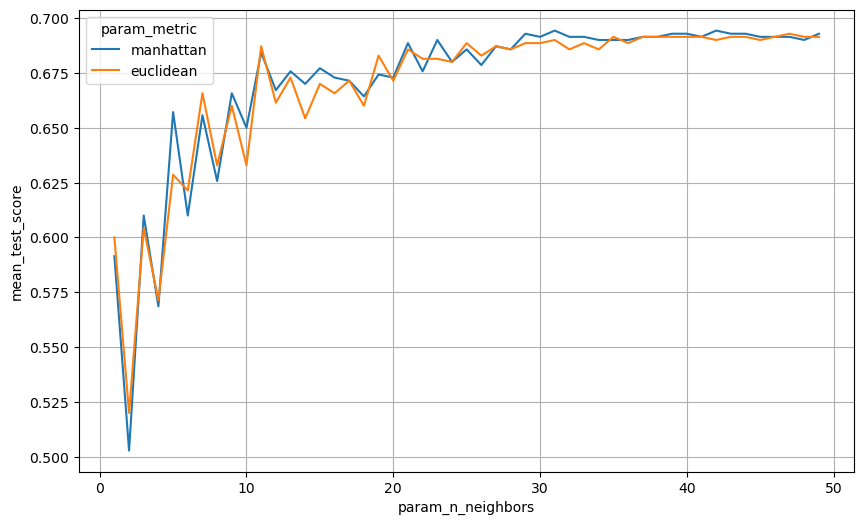

In [99]:
# 튜닝 과정 로그를 df로 저장
result = pd.DataFrame(model2.cv_results_)

plt.figure(figsize = (10,6))
sns.lineplot(x='param_n_neighbors', y='mean_test_score', data = result, hue = 'param_metric')
plt.grid()
plt.show()

In [100]:
pred2 = model2.predict(x_val_s)
print(confusion_matrix(y_val, pred2))
print(classification_report(y_val, pred2))

[[  0  85]
 [  2 213]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        85
           1       0.71      0.99      0.83       215

    accuracy                           0.71       300
   macro avg       0.36      0.50      0.42       300
weighted avg       0.51      0.71      0.60       300



### (3) Logistic Regression

In [101]:
model3 = LogisticRegression()
model3.fit(x_train, y_train)
pred3 = model3.predict(x_val)
print(confusion_matrix(y_val, pred3))
print(classification_report(y_val, pred3))

[[ 32  53]
 [ 25 190]]
              precision    recall  f1-score   support

           0       0.56      0.38      0.45        85
           1       0.78      0.88      0.83       215

    accuracy                           0.74       300
   macro avg       0.67      0.63      0.64       300
weighted avg       0.72      0.74      0.72       300



## 2.변수 중요도 비교
* 세 모델간 변수 중요도를 비교해 봅시다. 

### (1) RF

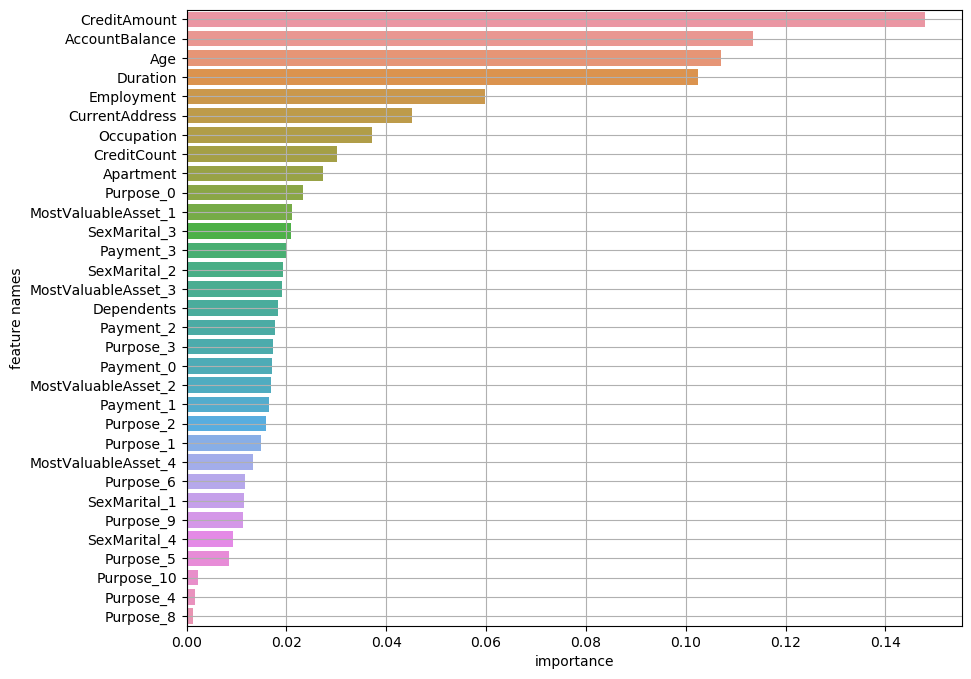

In [102]:
result1 = plot_feature_importance(model1.feature_importances_, list(x))

### (2) KNN

**Permutation Feature Importance**

![](https://github.com/DA4BAM/image/blob/main/PFI.png?raw=true)

In [22]:
from sklearn.inspection import permutation_importance

In [23]:
pfi1 = permutation_importance(model2, x_val_s, y_val, n_repeats=10, 
                              scoring = 'accuracy', random_state=20)

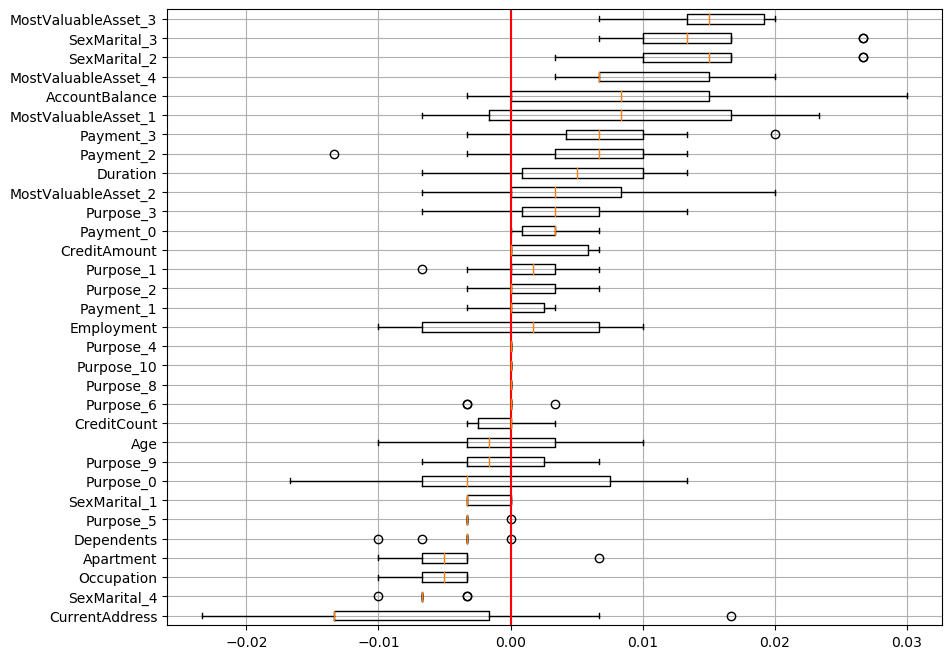

In [24]:
sorted_idx = pfi1.importances_mean.argsort()
plt.figure(figsize = (10, 8))
plt.boxplot(pfi1.importances[sorted_idx].T, vert=False, labels=x.columns[sorted_idx])
plt.axvline(0, color = 'r')
plt.grid()
plt.show()

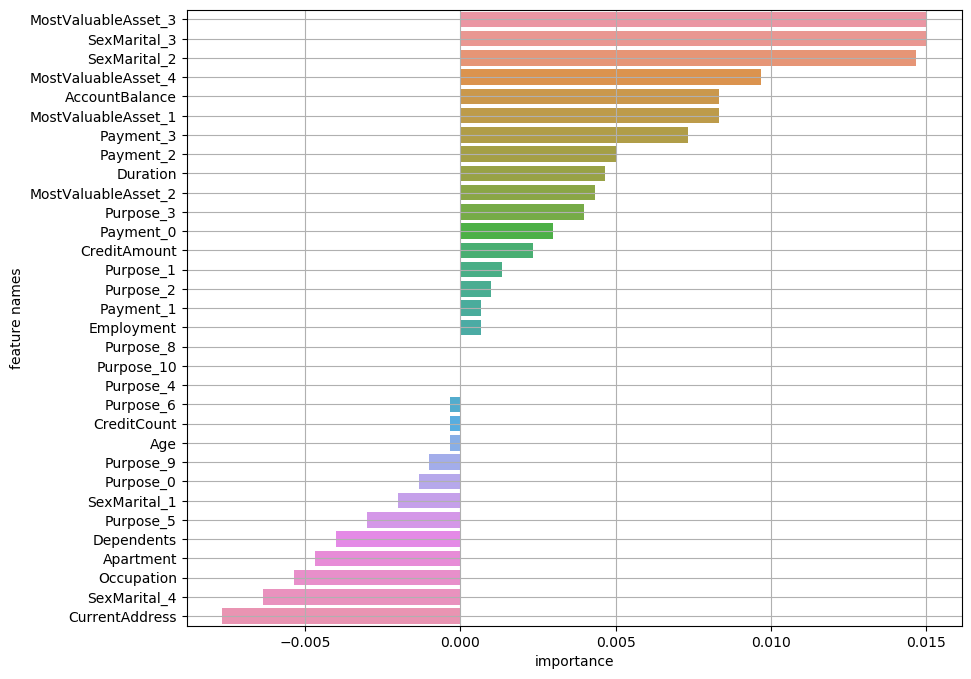

In [26]:
result2 = plot_feature_importance(pfi1.importances_mean, list(x_train))

### (3) LogisticRegression

In [27]:
pfi2 = permutation_importance(model3, x_val, y_val, n_repeats=10, 
                              scoring = 'accuracy', random_state=20)

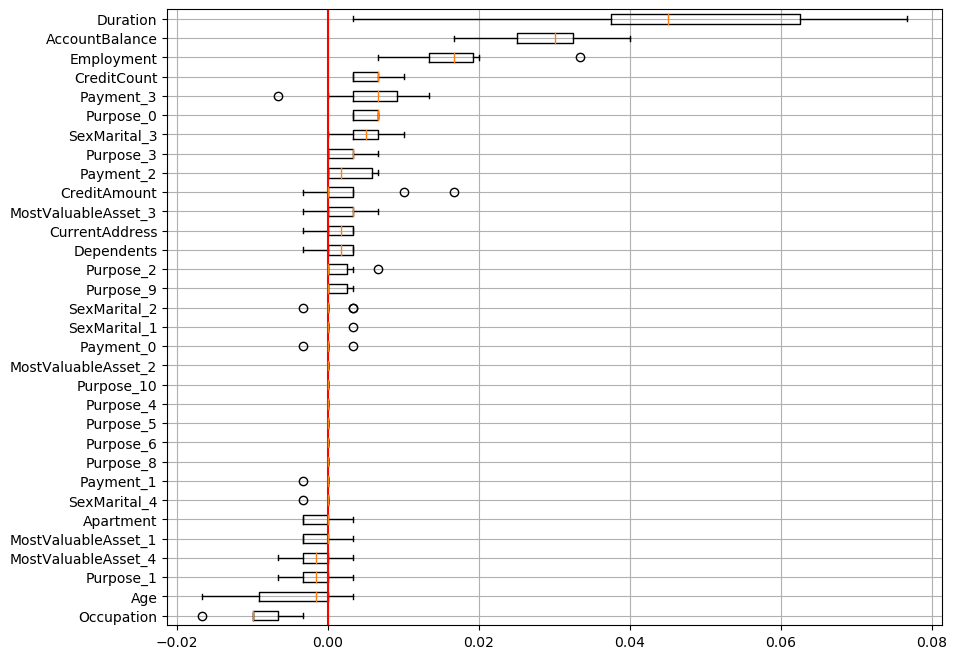

In [28]:
sorted_idx = pfi2.importances_mean.argsort()
plt.figure(figsize = (10, 8))
plt.boxplot(pfi2.importances[sorted_idx].T, vert=False, labels=x.columns[sorted_idx])
plt.axvline(0, color = 'r')
plt.grid()
plt.show()

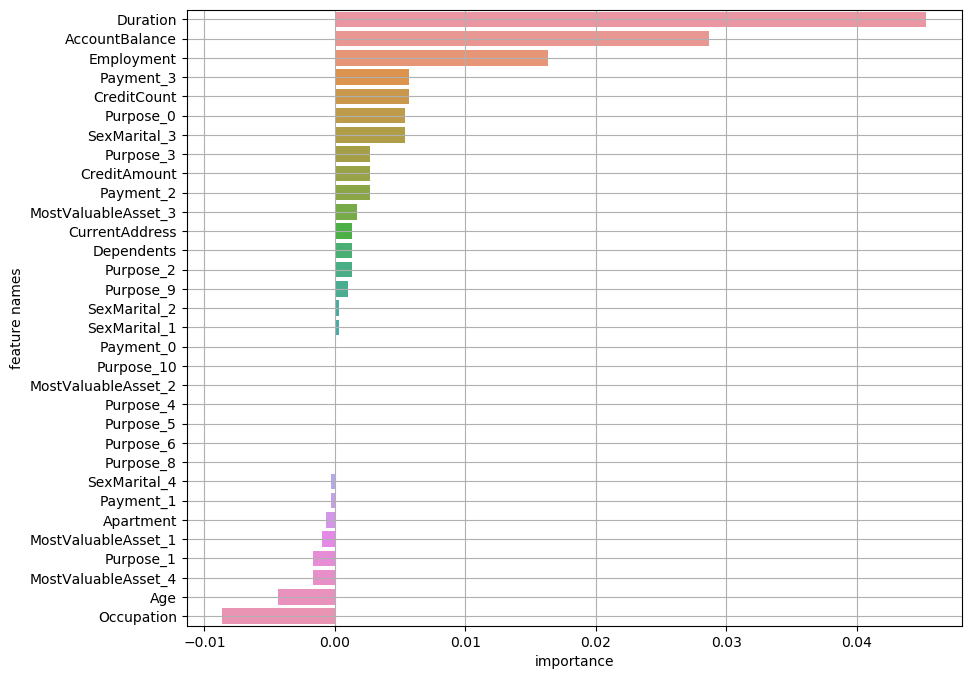

In [29]:
result2 = plot_feature_importance(pfi2.importances_mean, list(x_train))

## 3.PDP
* 중요한 feature의 값에 따라 예측값은 어떻게 변하는지 분석해 봅시다.
    * RF의 변수 중요도 상위 몇개에 대해서, 값의 변화에 따른 예측값 변화를 살펴봅시다.

In [30]:
from sklearn.inspection import PartialDependenceDisplay, partial_dependence

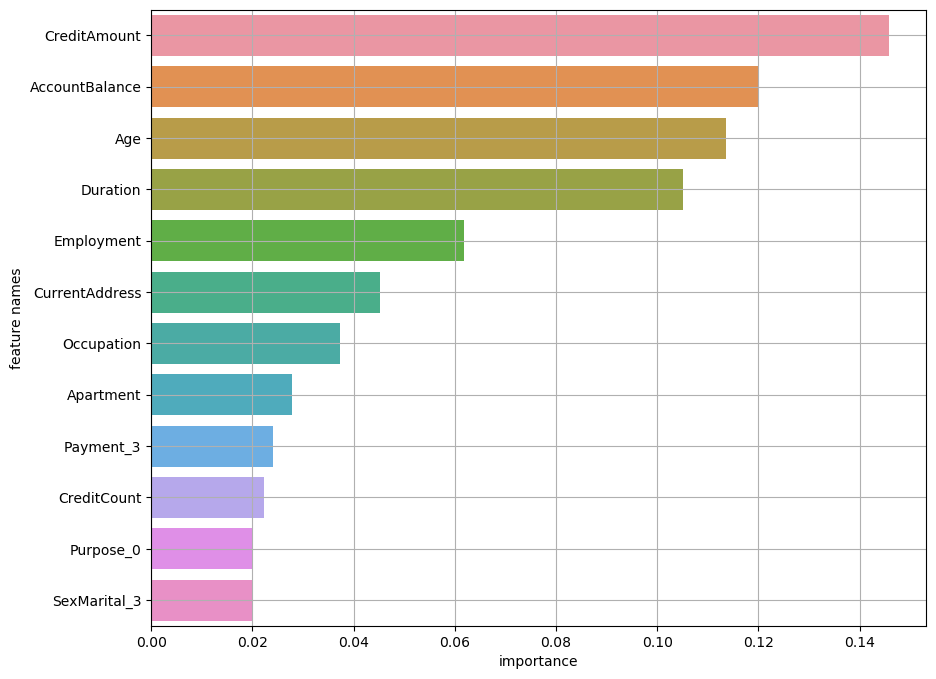

In [32]:
r2 = plot_feature_importance(model1.feature_importances_, list(x),12)

In [33]:
plt.rcParams['figure.figsize'] = 10, 6

* CreditAmount

(<Figure size 1500x950 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f92facdd970>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f92facddc10>})

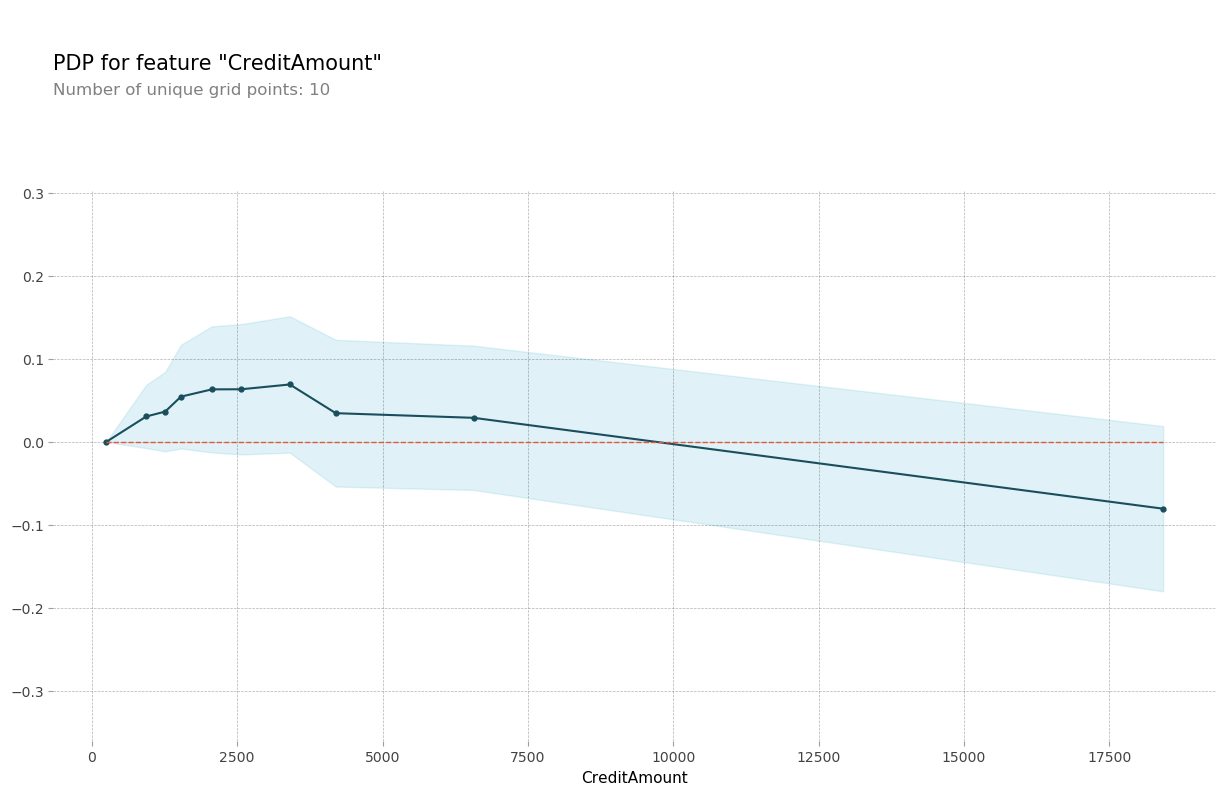

In [34]:
var = "CreditAmount"

isolated = pdp_isolate( model1, dataset=x_val, model_features= list(x_val),
                        feature=var, grid_type="percentile")
pdp_plot(isolated, feature_name=var)

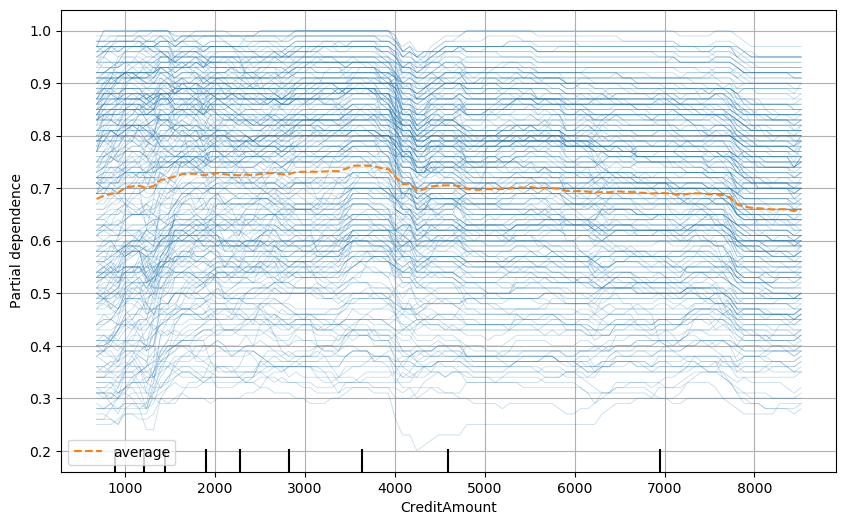

In [35]:
var = 'CreditAmount'

PartialDependenceDisplay.from_estimator(model1, features = [var], X = x_val, kind = 'both')
plt.grid()
plt.show()

* AccountBalance

(<Figure size 1500x950 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f92facec700>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f93004d91f0>})

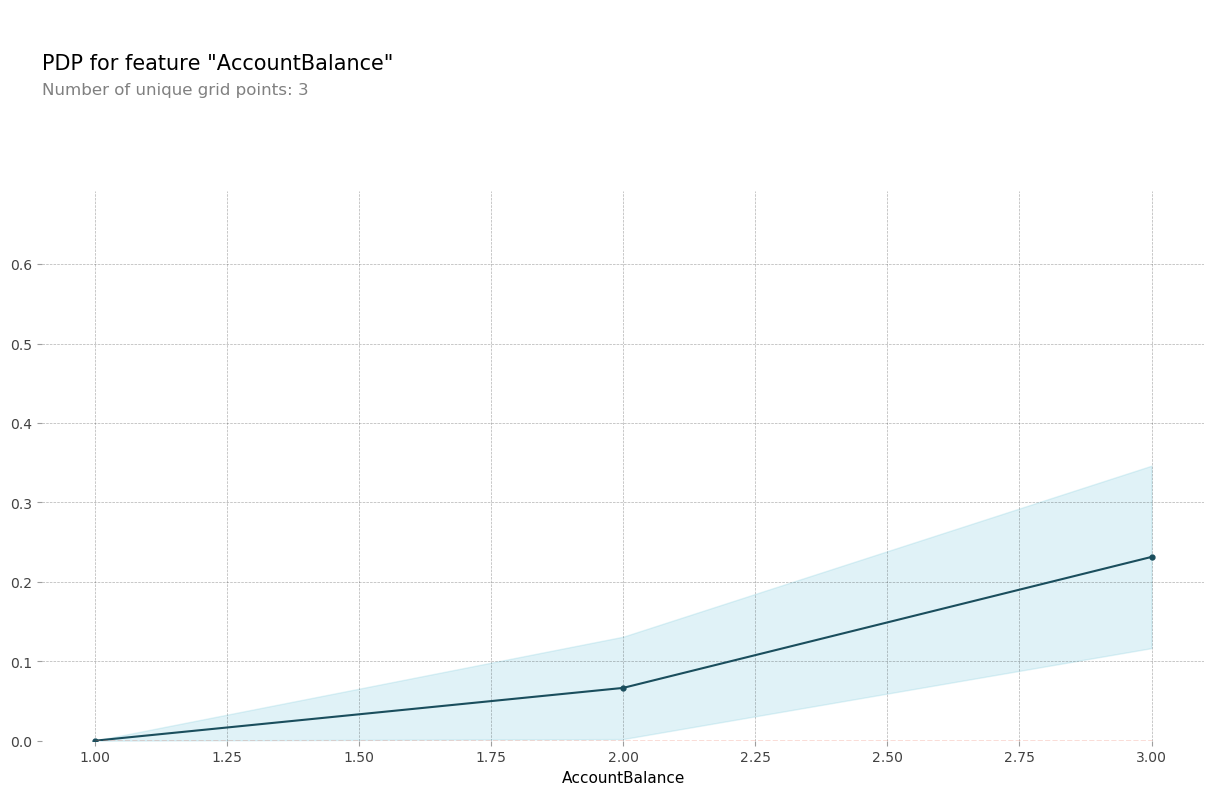

In [ ]:
var = "AccountBalance"

isolated = pdp_isolate( model1, dataset=x_val, model_features= list(x_val),
                        feature=var, grid_type="percentile")
pdp_plot(isolated, feature_name=var)

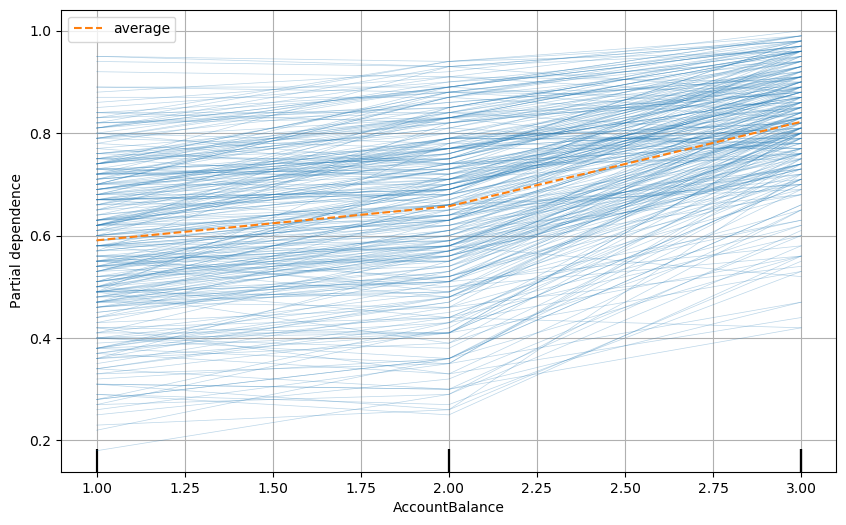

In [ ]:
var = 'AccountBalance'

PartialDependenceDisplay.from_estimator(model1, features = [var], X = x_val, kind = 'both')
plt.grid()
plt.show()

* Duration

(<Figure size 1500x950 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f93005605e0>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f92fada1a60>})

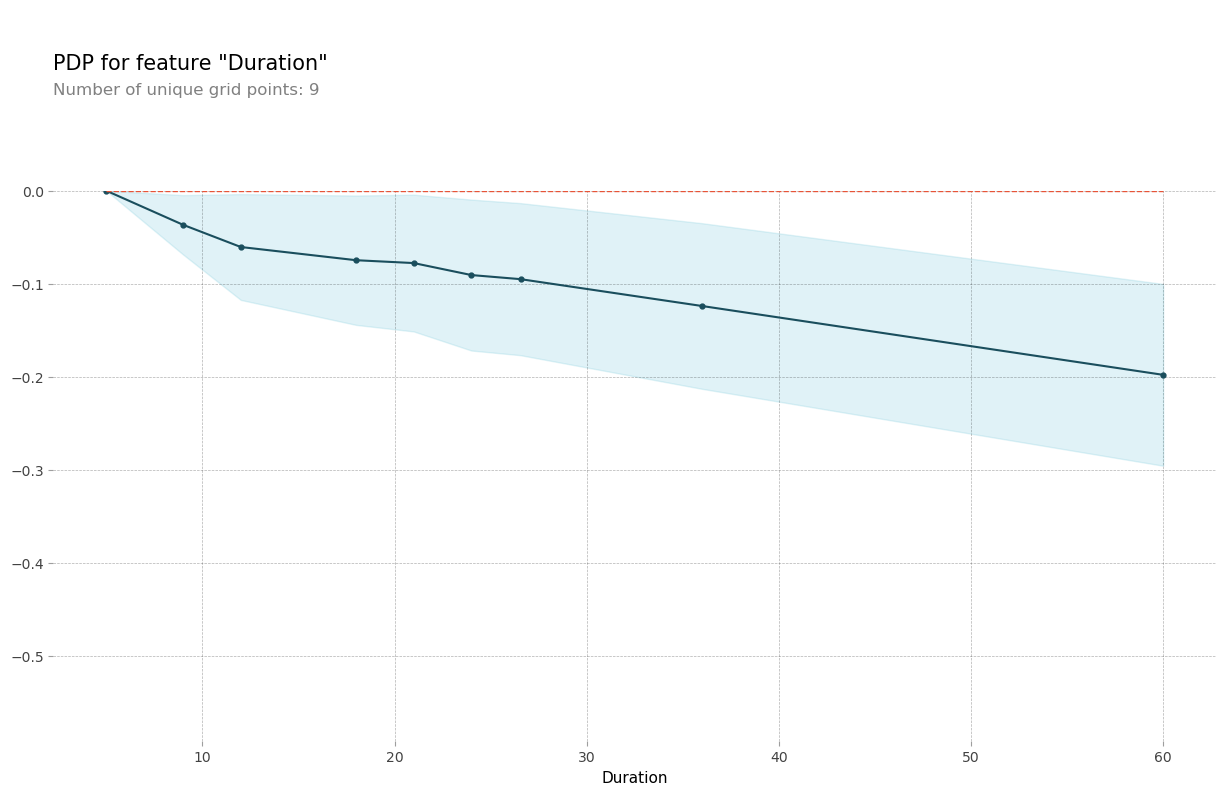

In [38]:
var = "Duration"

isolated = pdp_isolate( model1, dataset=x_val, model_features= list(x_val),
                        feature=var, grid_type="percentile")
pdp_plot(isolated, feature_name=var)

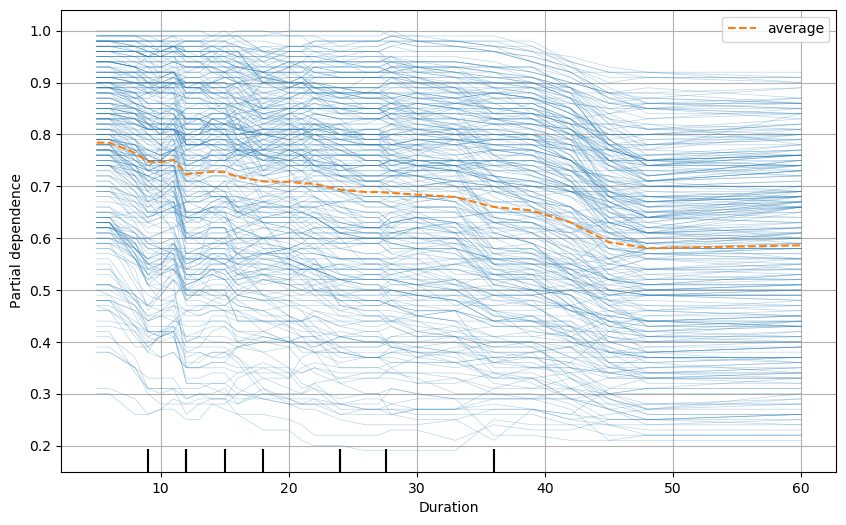

In [39]:
var = 'Duration'

PartialDependenceDisplay.from_estimator(model1, features = [var], X = x_val, kind = 'both')
plt.grid()
plt.show()

* Age

(<Figure size 1500x950 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f9300fca940>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f9300fca2e0>})

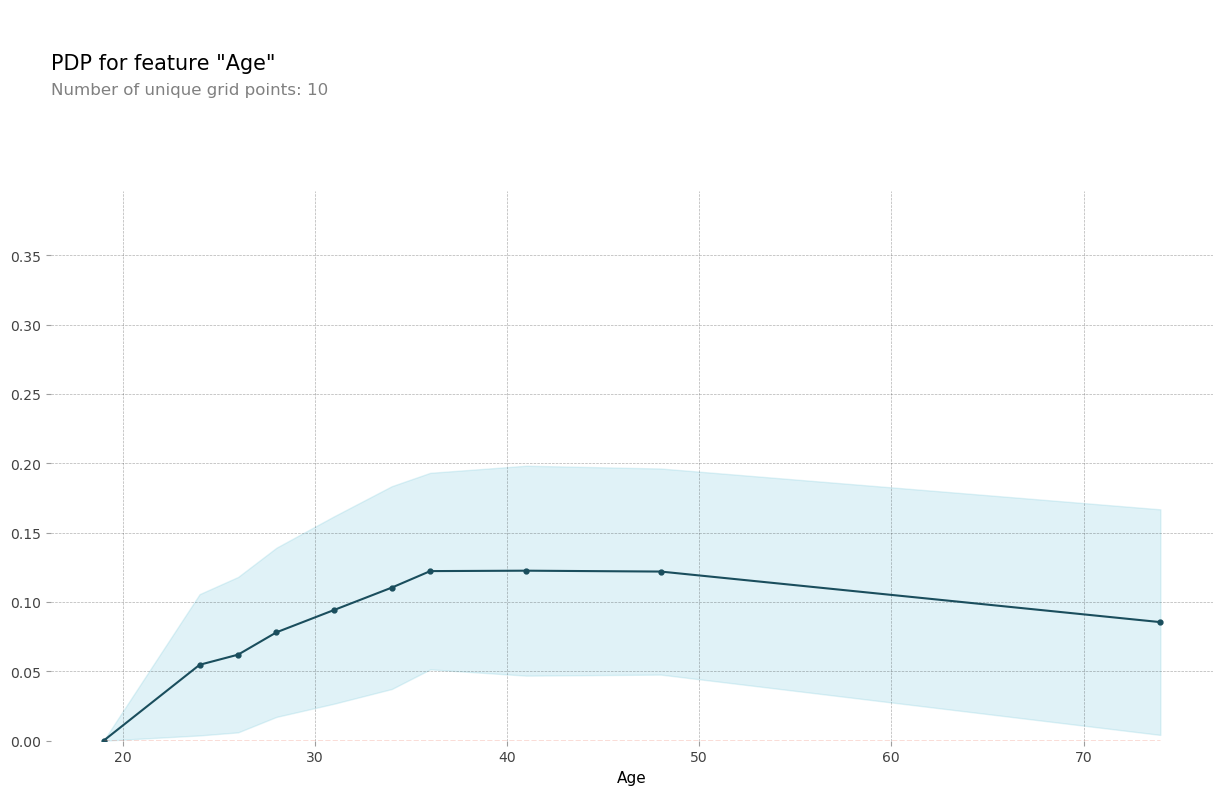

In [40]:
var = "Age"

isolated = pdp_isolate( model1, dataset=x_val, model_features= list(x_val),
                        feature=var, grid_type="percentile")
pdp_plot(isolated, feature_name=var)

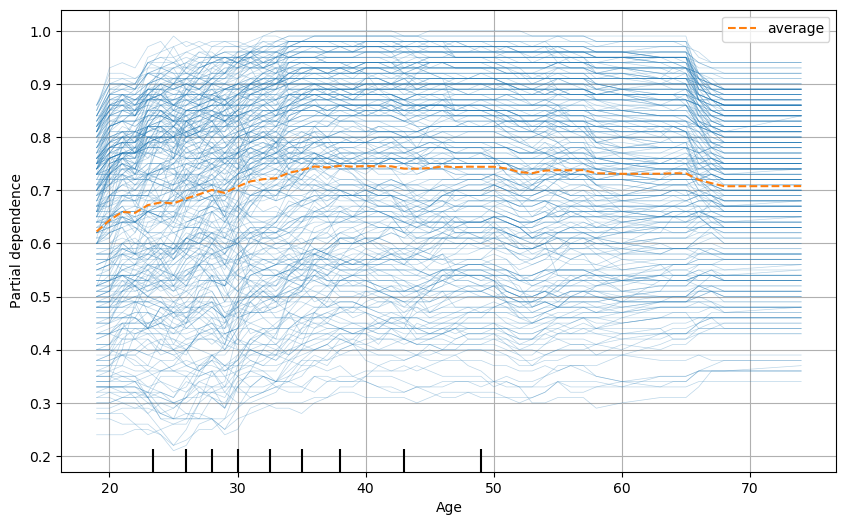

In [41]:
var = 'Age'

PartialDependenceDisplay.from_estimator(model1, features = [var], X = x_val, kind = 'both')
plt.grid()
plt.show()

* 조합1

In [42]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

(<Figure size 750x950 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f9300319ee0>,
  'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f930024b7f0>})

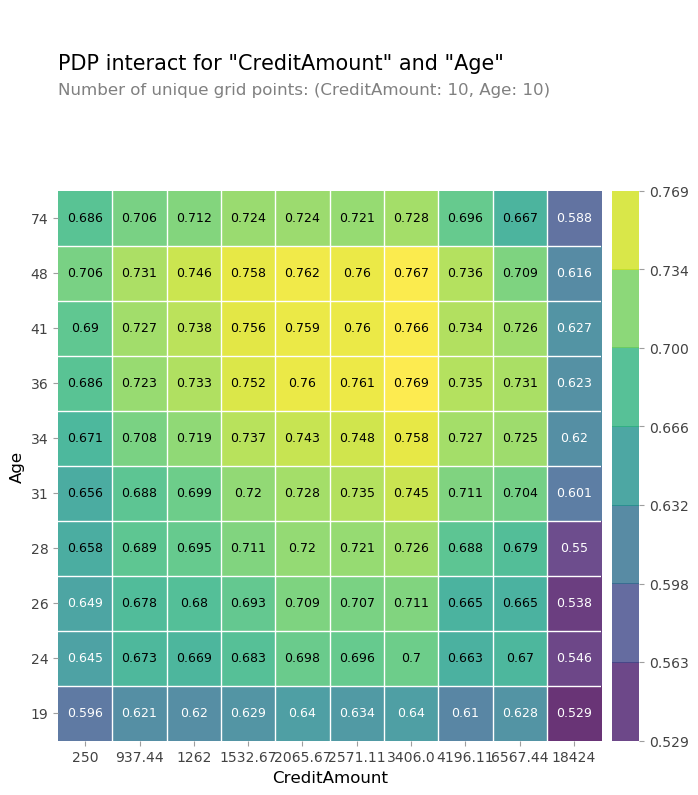

In [43]:
vars = ['CreditAmount','Age']

interaction = pdp_interact(model1, dataset= x_val, model_features= list(x_val),
                            features=vars,
)
pdp_interact_plot(interaction, plot_type="grid", feature_names=vars)

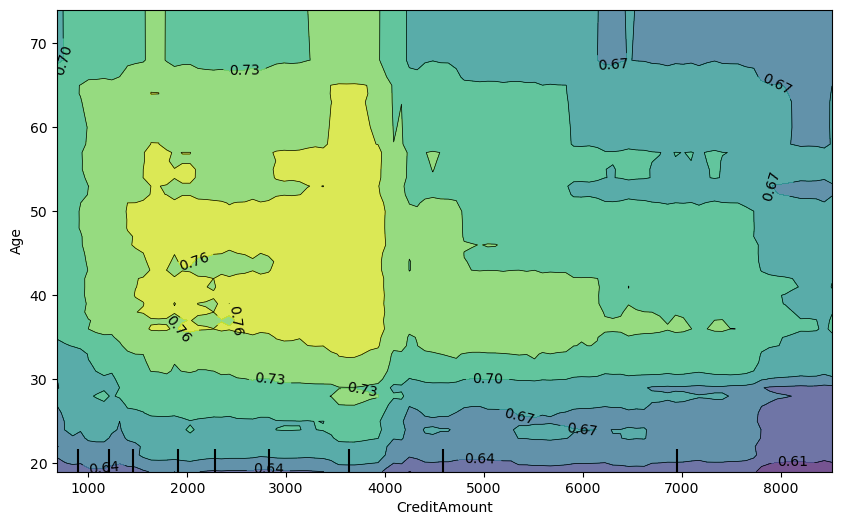

In [44]:
PartialDependenceDisplay.from_estimator(model1, features = [('CreditAmount','Age')], X = x_val)
plt.show()

* 조합2

(<Figure size 750x950 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f92fa739a00>,
  'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f92fa6da0a0>})

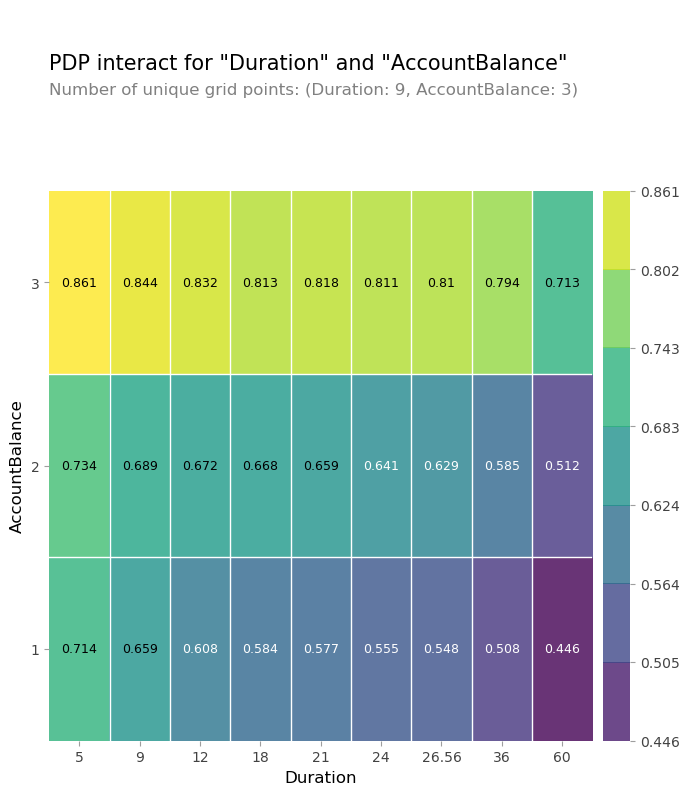

In [45]:
vars = ['Duration','AccountBalance']

interaction = pdp_interact(model1, dataset= x_val, model_features= list(x_val),
                            features=vars,
)
pdp_interact_plot(interaction, plot_type="grid", feature_names=vars)

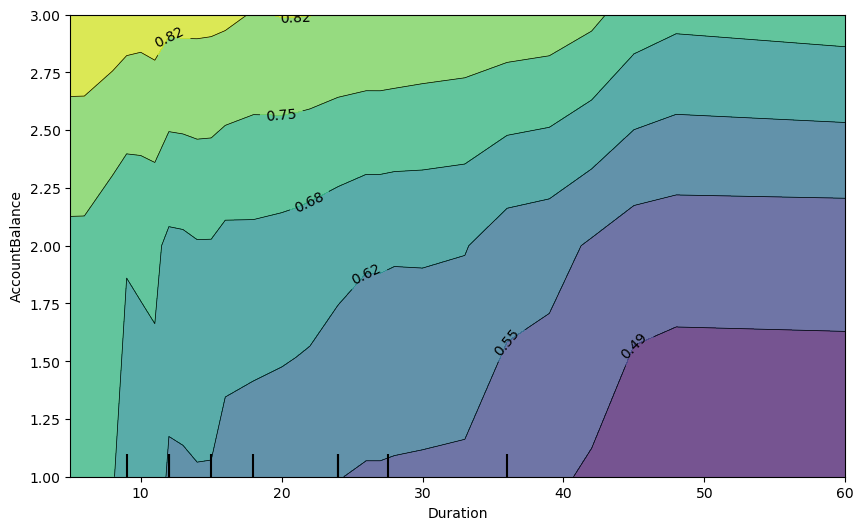

In [46]:
PartialDependenceDisplay.from_estimator(model1, features = [('Duration','AccountBalance')], X = x_val)
plt.show()

* 여러분이 작성한 예측 모델에 대한 **중요 요인 보고서**로
고객은 모델의 성능에 대해 신뢰를 갖게 되었습니다.
* 현장 전문가들이 가지고 있는 직관과 대체로 일치하기도 했지만,
생각지 못했던 변수가 중요하게 작용함을 알게 된 것은, 고객에게 신선한 충격이 되었습니다.



![](https://github.com/DA4BAM/image/blob/main/%EB%AA%A8%EB%8D%B8%ED%95%B4%EC%84%9D2.png?raw=true)

-----

# 과제2. 고객별 신용도 예측결과에 영향을 주는 요인은?

* 이제 운영 시스템에 배포하고 베타 오픈을 하였습니다.
    * 대출창구에서는 대출심사결과를 기다려야 하는 번거로움이 사라져서 환영하는 분위기 입니다.
    * 그런데 한가지 문제가 발생했습니다. **신용평가가 낮게 나온 고객 한 명이 강한 불만을 제기**하였습니다. 자신의 대출신청이 왜 반려되었는지 이해할수 없다는 것이었습니다.
    * 현장 직원은 인공지능이 그렇게 판단했다고 이야기 하는 것이 적절한 답변이 아니라고 판단하여, 제대로 된 답변을 하지 못했습니다.

* 고객사는 다시 여러분에게 요청을 해 왔습니다. **개별 신용평가 결과에 대한 근거를 제시**해 달라는 것입니다. 


![](https://github.com/DA4BAM/image/blob/main/%EB%AA%A8%EB%8D%B8%ED%95%B4%EC%84%9D3.png?raw=true)

* 자...이 고객의 반려 사유를 분석해서 알려드립시다~~!

## 4.ICE plot

* 하나의 인스턴스에서, 특정 feature 값에 따른 예측 영향도를 파악하기 위해 함수를 만들고 그래프를 그려봅시다.

In [47]:
temp = x_val.copy()
temp.reset_index(drop = True, inplace = True)

In [117]:
# 156 번 고객이라고 합시다.
temp.loc[[156]]

,AccountBalance,Duration,CreditAmount,Employment,CurrentAddress,Age,Apartment,CreditCount,Occupation,Dependents,...,Purpose_9,Purpose_10,SexMarital_1,SexMarital_2,SexMarital_3,SexMarital_4,MostValuableAsset_1,MostValuableAsset_2,MostValuableAsset_3,MostValuableAsset_4
156,2,12,983,2,4,19,1,1,2,1,...,0,0,0,1,0,0,1,0,0,0


In [115]:
# ICE plot 함수 생성
def ice_plot(data, var, id, model) :
    '''
    input 설명
        * data : 데이터셋
        * var : 특정 feature
        * id : 특정 인스턴스, 분석단위...
        * 설명할 모델
    '''

    temp = data.loc[[id]]
    var_values = data[var].sort_values().tolist()
    pred = []
    for v in var_values :
        temp[var] = v
        pred.append(model.predict_proba(temp)[0,1])

    plt.plot(var_values, pred, marker = '.')
    plt.grid()
    plt.show()

* 나이에 따른 예측값 변화

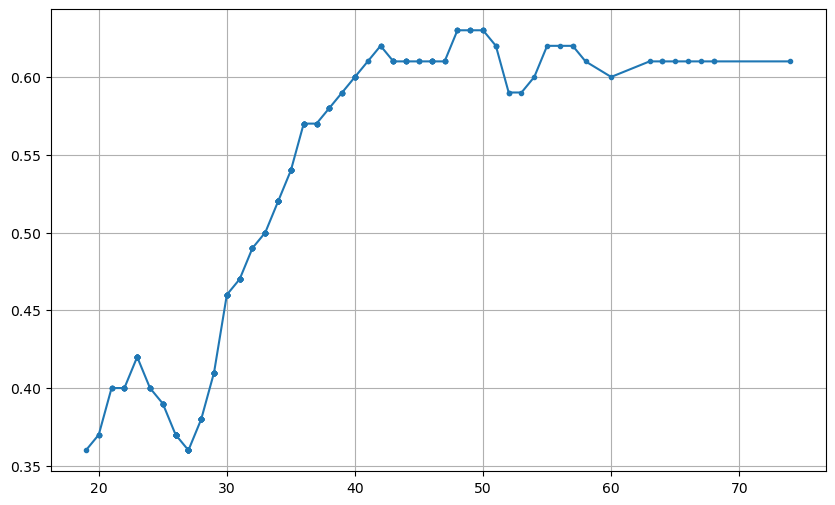

In [51]:
ice_plot(temp, 'Age', 156, model1)

* 대출신청금액에 따른 예측값 변화

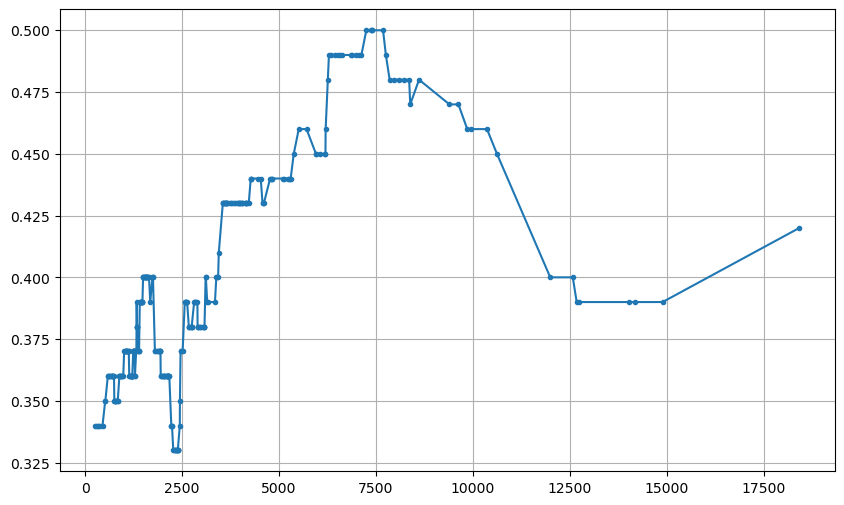

In [52]:
ice_plot(temp, 'CreditAmount', 156, model1)

* 대출기간에 따른 예측값 변화

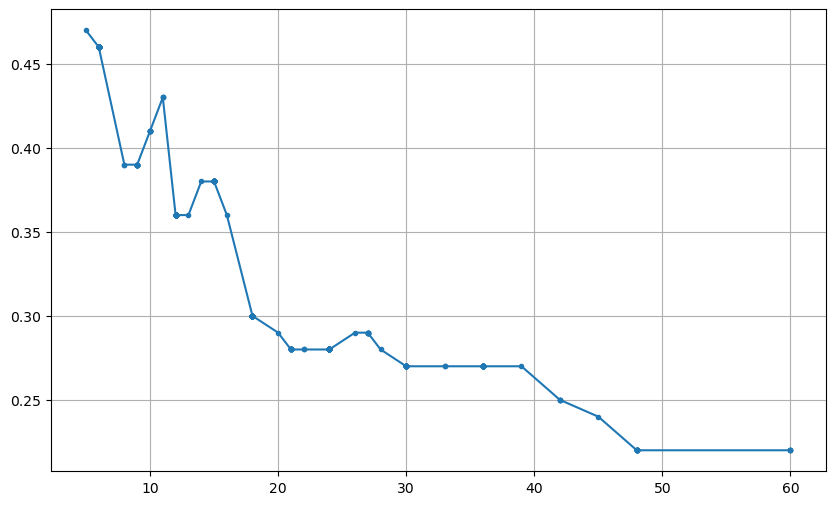

In [53]:
ice_plot(temp, 'Duration', 156, model1)

* 계좌 정보에 따른 예측값 변화

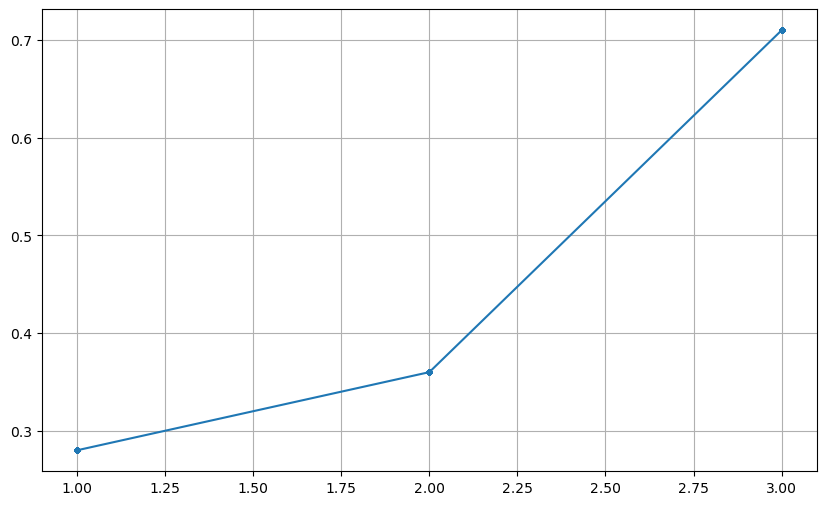

In [54]:
ice_plot(temp, 'AccountBalance', 156, model1)

## 5.SHAP

* 이번에는 shap 값을 이용해서 고객의 예측값이 낮게 나온 요인을 찾아 봅시다.

In [63]:
# shap.TreeExplainer 함수를 통해 모델에 explainer 생성
explainer = shap.TreeExplainer(model1)

# SHAP 값 저장
shap_values = explainer.shap_values(temp)

In [64]:
# 영향도 그래프 그리기
shap.initjs()
idx = 156

# 예측값의 평균 0.7115 대비, 인덱스 156 의 예측값 0.36 인 요인 분석.
shap.force_plot(explainer.expected_value[1], shap_values[1][idx, :], temp.iloc[idx,:])

* SHAP은 개별 데이터 분석 이외에도 다양한 분석 함수들이 제공됩니다. 
* 추후에 꼭 공부해보세요~~!

----

**고객의 신용도 평가 근거 마련!**
* **고객의 신용도 평가에 대한 근거**를 제시해 줌으로써, 현장 직원의 만족도가 굉장히 높아졌습니다.  
* 물론  모든 고객이 제시된 근거에 불만이 없는 것은 아닙니다. 하지만, 현장 창구에서는 오히려 고객에게 적극적으로 고객신용도 개선을 위한 제안도 하게 되었습니다!


![](https://github.com/DA4BAM/image/blob/main/%EB%AA%A8%EB%8D%B8%ED%95%B4%EC%84%9D4.png?raw=true)

-----

# 과제3. 신용도가 낮은 고객을 잘 못 맞추고 있군요!

* 현장의 환호도 잠시...다시 고객사에서 연락이 왔습니다. 
* **"아니...신용도가 낮은 고객이 회사에 더 위험한데, 이런 고객을 제대로 예측해 내지 못하고 있더군요!"**
* 여러분 머리 속은 하얗게 되었습니다. 클래스 불균형을 살피지 않았네...ㅜㅜ
* 자, 아직 프로젝트가 끝난 것은 아니니 너무 상심하지 맙시다. ~(처음부터 다시 시작하면 됩니다.)~

![](https://github.com/DA4BAM/image/blob/main/%EB%AA%A8%EB%8D%B8%ED%95%B4%EC%84%9D9.png?raw=true)

## 6.Class Imbalance 문제 해결

### (1) 현재 결과

In [103]:
pred1 = model1.predict(x_val)
print(confusion_matrix(y_val, pred1))
print(classification_report(y_val, pred1))

[[ 32  53]
 [ 18 197]]
              precision    recall  f1-score   support

           0       0.64      0.38      0.47        85
           1       0.79      0.92      0.85       215

    accuracy                           0.76       300
   macro avg       0.71      0.65      0.66       300
weighted avg       0.75      0.76      0.74       300



### (2) Resampling 후 모델링
* down, up, smote 모두 시도해 봅시다.

In [104]:
from imblearn.under_sampling import RandomUnderSampler # down
from imblearn.over_sampling import RandomOverSampler, SMOTE  # up, smote

* 리샘플링!

In [105]:
# 다운샘플링
rus = RandomUnderSampler(random_state = 4)
x_train_d, y_train_d = rus.fit_resample(x_train, y_train)

# 업샘플링
ros = RandomOverSampler(random_state = 4)
x_train_u, y_train_u = ros.fit_resample(x_train, y_train)

# SMOTE
smote = SMOTE(random_state = 4)
x_train_sm, y_train_sm = smote.fit_resample(x_train, y_train)

* 다운샘플링 데이터로 모델링

In [106]:
model1_d = RandomForestClassifier()
model1_d.fit(x_train_d, y_train_d)
pred1_d = model1_d.predict(x_val)
print(confusion_matrix(y_val, pred1_d))
print(classification_report(y_val, pred1_d))

[[ 60  25]
 [ 71 144]]
              precision    recall  f1-score   support

           0       0.46      0.71      0.56        85
           1       0.85      0.67      0.75       215

    accuracy                           0.68       300
   macro avg       0.66      0.69      0.65       300
weighted avg       0.74      0.68      0.69       300



* 업샘플링 데이터로 모델링

In [107]:
model1_u = RandomForestClassifier()
model1_u.fit(x_train_u, y_train_u)
pred1_u = model1_u.predict(x_val)
print(confusion_matrix(y_val, pred1_u))
print(classification_report(y_val, pred1_u))

[[ 44  41]
 [ 29 186]]
              precision    recall  f1-score   support

           0       0.60      0.52      0.56        85
           1       0.82      0.87      0.84       215

    accuracy                           0.77       300
   macro avg       0.71      0.69      0.70       300
weighted avg       0.76      0.77      0.76       300



* SMOTE 샘플링 데이터로 모델링

In [108]:
model1_sm = RandomForestClassifier()
model1_sm.fit(x_train_sm, y_train_sm)
pred1_sm = model1_sm.predict(x_val)
print(confusion_matrix(y_val, pred1_sm))
print(classification_report(y_val, pred1_sm))

[[ 40  45]
 [ 27 188]]
              precision    recall  f1-score   support

           0       0.60      0.47      0.53        85
           1       0.81      0.87      0.84       215

    accuracy                           0.76       300
   macro avg       0.70      0.67      0.68       300
weighted avg       0.75      0.76      0.75       300



### (3) class_weight 조절

* balanced

In [109]:
# 모델링 및 평가
model_wb = RandomForestClassifier(class_weight='balanced')
model_wb.fit(x_train, y_train)
pred_wb = model_wb.predict(x_val)

print(confusion_matrix(y_val, pred_wb))
print(classification_report(y_val, pred_wb))

[[ 30  55]
 [ 18 197]]
              precision    recall  f1-score   support

           0       0.62      0.35      0.45        85
           1       0.78      0.92      0.84       215

    accuracy                           0.76       300
   macro avg       0.70      0.63      0.65       300
weighted avg       0.74      0.76      0.73       300



### (4) 추가 실험
* 랜덤하게 처리된 부분이 있다면, 
* 한번 나온 결과를 그대로 받아들이기 보다는
* 여러번 반복 수행하고, 결과의 분포로 비교하기를 권장합니다.

1) 모델링 100번 반복수행하며 f1 스코어 저장하기

In [116]:
# 랜덤포레스트로 모델링 및 검증(f1 score)하는 함수 생성
def rf_modeling(x_train, y_train, x_val, y_val, cw = None) :
    m = RandomForestClassifier(class_weight = cw)
    m.fit(x_train, y_train)
    pred = m.predict(x_val)
    return f1_score(y_val,pred, pos_label=0) # 0 : 신용도 낮은 고객

In [76]:
from tqdm import tqdm

In [88]:
# 결과를 담을 빈 리스트 선언
result_d, result_u, result_s, result_cw = [], [], [], []

# 리샘플러들 선언
down_sampler = RandomUnderSampler()
up_sampler = RandomOverSampler()
smote = SMOTE()

# 100번 반복하며...
for i in tqdm(range(100)):

    # 데이터분할 & 리샘플링(랜덤하게!!!!)
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = .3)
    d_x_train, d_y_train = down_sampler.fit_resample(x_train, y_train)
    u_x_train, u_y_train = up_sampler.fit_resample(x_train, y_train)
    s_x_train, s_y_train = smote.fit_resample(x_train, y_train)

    # 모델링 및 검증성능(f1) 저장하기
    result_d.append(rf_modeling(d_x_train, d_y_train, x_val, y_val))
    result_u.append(rf_modeling(u_x_train, u_y_train, x_val, y_val))
    result_s.append(rf_modeling(s_x_train, s_y_train, x_val, y_val))
    result_cw.append(rf_modeling(x_train, y_train, x_val, y_val, 'balanced'))

100%|██████████| 100/100 [02:12<00:00,  1.32s/it]


2) 결과를 그래프로 비교해 봅시다.

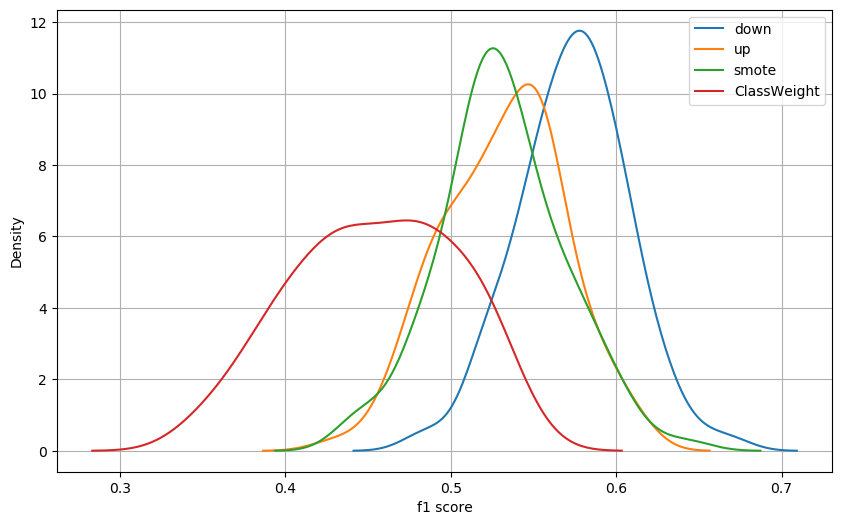

In [89]:
plt.figure(figsize=(10, 6))
sns.kdeplot(result_d, label= 'down')
sns.kdeplot(result_u, label = 'up')
sns.kdeplot(result_s, label = 'smote' )
sns.kdeplot(result_cw, label = 'ClassWeight' )

plt.xlabel('f1 score')
plt.legend()
plt.grid()
plt.show()

----

* 여러분의 노력으로 전체 성능은 조금 낮아졌지만,
* **신용도가 낮은 사람의 예측 정확도를 조금 향상**시켰습니다!
* 고객사에서는 여러분의 노력에 감사하고 있지만, 아주 만족스러워하지는 않고 있습니다. ~(뭐지?)~

-------

# 과제4. 모델은 수익의 문제를 해결한건가요?

* 이제 인공지능에 의한 신용평가 시스템은 큰 무리 없이 작동하며 한 달간 운영되어 오고 있습니다. 
* 그 동안의 운영 및 프로젝트 완료 보고서를 작성해야 할 시점입니다.
* 그런데, 인공지능 신용평가 시스템에 대해 처음부터 부정적인 견해를 가져온 고객사 임원이, 또 다른 요구를 제기해 왔습니다.
* "구체적으로 **어떤 비즈니스 성과를 가져다 줄 것인지**를 설명해 주세요." ~(이런게 갑질???)~

![](https://github.com/DA4BAM/image/blob/main/%EB%AA%A8%EB%8D%B8%ED%95%B4%EC%84%9D5.png?raw=true)

* 또 다시 여러분에게 미션이 주어졌습니다. **인공지능 모델의 결과를 어떻게 비즈니스 성과로 연결할 수 있을까요?**
* 여러분이 누구입니까? 그 유명한! **코드스테이츠 부트캠프 18기!**
* 고객사의 과거자료를 검토하며 다음과 같이 대출 수익구조를 정리하게 되었습니다.
    * 제 때 대출이자와 원금을 상환하는 고객으로부터, 평균적으로 대출금의 약 4%(연) 이자 수익이 발생 되었습니다. 
    * 제 때 상환하지 않는 고객으로 인해, 평균적으로 약 9%의 원금 손실(연)이 발생됩니다. 
    * 평균 대출 금액은 약 3200달러, 평균 대출 기간은 2년 입니다.
    * 여러분은, 대출을 했을 때 2년후의 기대가치를 계산해야 합니다.

## 7.비즈니스 기대가치 평가
* 대출신청자들에 대해서 우리는 1인당 기대가치를 계산하고 모델을 이것으로 평가하고자 합니다.
* 지금까지 생성한 모든 모델에 대해서 모두 기대가치 수익액으로 환산하고 비교해 봅시다.

### (1) 모델의 성적표 (Confusion matrix)
* 모델의 성적표는 confusion maxtix 자체 입니다.
* 이미 모델을 만들고 검증했으니 그것을 그대로 이용합시다.
* 단 1인당 기대수익액을 계산할 것이므로 confusion matrix를 비율로 변환합니다.

In [110]:
# confusion matrix로 저장합니다.
cm = confusion_matrix(y_val, pred1)
cm

array([[ 32,  53],
       [ 18, 197]])

In [111]:
# 비율로 환산. 1인당 기대가치 계산을 위해
cm_p = cm / np.sum(cm)
cm_p

array([[0.10666667, 0.17666667],
       [0.06      , 0.65666667]])

### (2) 비즈니스 가치 matrix
* 이것이 핵심입니다.
* 비즈니스 상황을 검토하여 비즈니스 가치 매트릭스를 만들어 내야 합니다.
* 이것을 정리하기 위해서는, 우리가 **예측한 모델로 고객은 어떤 액션을 취하는지** 정해야 합니다!
    * 신용도가 낮게 예측된 고객 ➡ 신용대출신청 반려
    * 신용도가 높게 예측된 고객 ➡ 신용대출신청 승인
* 이런 **액션**으로 어떤 일이 벌어지게 될까요?
    * 신용대출신청 반려 ➡ 신용도가 낮은 고객이 맞았을때, 혹은 틀렸을때
    * 신용대출신청 승인 ➡ 신용도가 높은 고객이 맞았을때, 혹은 틀렸을때

In [112]:
bv = np.array([[0,-0.18],[-0.08,0.08]])
bv

array([[ 0.  , -0.18],
       [-0.08,  0.08]])

### (3) 1인당 기대 수익액(기대가치) 계산하기
* 이제 모델의 성적표와 비즈니스 가치 매트릭스를 곱하면 됩니다.
    * 매트릭스 곱 연산이 아니라
    * 같은 위치끼리 곱하기(element wise multiply)

In [113]:
np.sum(cm_p * bv) * 3200

50.98666666666665

* 전체 예측값 비교(두둥~~)

In [114]:
model_list = ['rf','knn','lr','rf_d','rf_u','rf_sm','rf_wb']
pred = [pred1, pred2, pred3, pred1_d, pred1_u, pred1_sm, pred_wb]
biz_values = []
for i in range(7) :
    cm = confusion_matrix(y_val, pred[i])
    cm_p = cm / np.sum(cm)

    biz_values.append(np.sum(cm_p * bv) * 3200)

result = pd.DataFrame({'Model':model_list, 'Biz_Value':biz_values })
result


,Model,Biz_Value
0,rf,50.986667
1,knn,16.853333
2,lr,39.040000
3,rf_d,14.293333
4,rf_u,55.253333
5,rf_sm,50.986667
6,rf_wb,47.146667


* 위 표에서 value의 단위는 달러($) 입니다!
* **각 모델 별, 1인당 수익액으로 환산**하였습니다!
* 모델 평가를 Accuracy, Recall, Precision, AU-ROC 등의 기술적인 지표가 아닌, 비즈니스 지표로 평가하는 순간입니다!
* 최초, **문제정의**는 **수익 하락 문제를 해결**하려는 것이었습니다.
* 그리고 여러분은 **수익을 가장 끌어올릴 수 있는 모델을 선정**할수 있게 되었습니다! 

-------

**드디어, 끝났습니다!**
* 고객사가 지속적인 ~갑질~ 추가 사항을 요청 함에도, 여러분은 **최선을 다해 문제를 해결**해 주었습니다. 
* 고객사 CEO 는 여러분의 **적극적이고 흔들림 없는 태도**와 **헌신** 
* 그리고 **부트캠프에서 쌓은 실력**에 한껏 고무되어
* 여러분에게 **한가지 제안**을 하려고 합니다.   
...  
...  
...  
...  
...  
...  
...  
...  
...  
...  
...  
...  
...  
...  
...  
...  
...  
...  
...  
...  

![](https://github.com/DA4BAM/image/blob/main/%EB%AA%A8%EB%8D%B8%ED%95%B4%EC%84%9D8.png?raw=true)

부트캠프 18기 과정이 종료되면  
**여러분에게 이런 좋은일이 생기기**를 진짜 바랍니다!  
수고하셨습니다~~~!

------

* 데이터를 얻을 수 있는 곳
    * kaggle
    * uci repository : https://archive.ics.uci.edu/ml/datasets.php
    * 공공데이터 포털 : https://www.data.go.kr/
    * 서울시 열린데이터 : https://data.seoul.go.kr/
    * IBM Dataset : https://developer.ibm.com/?q=%20&DWContentType[0]=Datasets
    * DACON : https://dacon.io/
    * AI hub : https://aihub.or.kr/aihubdata/data/list.do?currMenu=115&topMenu=100
